# Getting the rating from the reviews

In [1]:
# !pip install -q --disable-pip-version-check -r ../requirements.txt

In [2]:
# Randomization for seed reproduction
import random

# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Regular Expressions
import re

# Import unidecode (to remove accents from words)
from unidecode import unidecode

# Import wordcloud
from wordcloud import WordCloud

# Sklearn Utilities
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation

# Visualize the information contained in a topic model
import pyLDAvis
from pyLDAvis import gensim as gensimvis

import gensim
from gensim import corpora

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.manifold import TSNE
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize

# Language Detection
from langdetect import detect


In [3]:
# Set a random seed for reproducibility
random_seed = 10
np.random.seed(random_seed)
random.seed(random_seed)

# Preprocessing

## 1. Displaying the data

In [4]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


Obtain an example from the dataset:

In [5]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [6]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [7]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [8]:
# display_ratings(reviews_df)

In [9]:
# display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

## 2. Data cleaning
We will discard everything but the review *review_text* as it is the only useful for the topic modelling process

In [10]:
# Get every column and drop everything except for review_text
reviews_df = reviews_df.drop(reviews_df.columns.difference(['review_text']), axis=1)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


### 2.1. Removing NaN and missing values

In [11]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [12]:
has_nan_or_missing_values(reviews_df)

review_text    False
dtype: bool
Number of samples: 18172


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [13]:
get_one_sample_with_columns(reviews_df)

[('review_text',
  'Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))')]

Obtain more information about the dataframe:

In [14]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18172 entries, 0 to 18171
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  18172 non-null  object
dtypes: object(1)
memory usage: 283.9+ KB


### 2.2. Text Preprocessing
We will only keep the Spanish reviews with the langdetect library. Otherwise, the TF_IDF matrix will be too sparse.

#### 2.2.1. Filter Spanish reviews

In [15]:
# Remove all non-Spanish reviews
# reviews_df = reviews_df[reviews_df['review_text'].apply(lambda x: detect(x) == 'es')]
# reviews_df.info()

In [16]:
# Reset the indeces
# reviews_df = reviews_df.reset_index(drop=True)

In [17]:
# Save the dataframe to a CSV file
# reviews_df.to_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv')

In [18]:
# Import the CSV file
reviews_df = pd.read_csv('../data/Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

,review_text
0,Un hotel muy bueno. El personal fue muy amabl...
1,"Muy buen hotel al nivel de lo esperado, habita..."
2,Magnífico hotel. La verdad es que todo perfect...
3,"Hotel hermoso, buen diseño, original, limpio. ..."
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.2. Remove punctuation

In [19]:
# Remove punctuation using regular expressions
# We just keep the words and spaces
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

reviews_df.head()

,review_text
0,Un hotel muy bueno El personal fue muy amable...
1,Muy buen hotel al nivel de lo esperado habitac...
2,Magnífico hotel La verdad es que todo perfecto...
3,Hotel hermoso buen diseño original limpio Serv...
4,Magnífica ubicación en pleno centro de Sevilla...


#### 2.2.3. Transform text to lowercase

In [20]:
# Transform all words to lowercase (consistency)
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: x.lower())

reviews_df.head()

,review_text
0,un hotel muy bueno el personal fue muy amable...
1,muy buen hotel al nivel de lo esperado habitac...
2,magnífico hotel la verdad es que todo perfecto...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación en pleno centro de sevilla...


#### 2.2.4. Remove Stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
from nltk.corpus import stopwords

In [23]:
# Initialize stopwords
stop_words = set(stopwords.words('spanish'))

# Define the text preprocessing function
def remove_stop_words(text):
    # Remove stop words
    words = text.split()  # Split text into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

In [24]:
# preprocess the df
reviews_df['review_text'] = reviews_df['review_text'].apply(remove_stop_words)

reviews_df.head()

,review_text
0,hotel bueno personal amable profesional gustab...
1,buen hotel nivel esperado habitación junior su...
2,magnífico hotel verdad perfecto habitación amp...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación pleno centro sevilla recor...


#### 2.2.5. Remove non-spanish words
Delete not spanish words or misspelled words that lead to errors and confusion
##### 3 hours to execute, please don't. Instead use the file Reduced_Topic_Modelling_Big_AHR_Spanish.csv

In [25]:
# from concurrent.futures import ThreadPoolExecutor
# from spellchecker import SpellChecker

# spanish = SpellChecker(language='es')

# def fix_non_words(text: str, column_n) -> str:
#     corrected_words = [spanish.correction(word) if spanish.correction(word) else '' for word in text.split()]
#     # print(f'{text} -> {corrected_words}')
#     return ' '.join(corrected_words)

# # Define the number of threads you want to use
# num_threads = 12

# # Create a ThreadPoolExecutor with the specified number of threads
# with ThreadPoolExecutor(max_workers=num_threads) as executor:
#     # Use the executor to apply the fix_non_words function to each element in the 'review_text' column concurrently
#     reviews_df['review_text'] = list(executor.map(fix_non_words, reviews_df['review_text'], reviews_df.index))


# save the dataframe to a CSV file
# reviews_df.to_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
2223
24

25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
4546
47

48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
7071
72
73

74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
9596
97
98

99
100
101
102
103
104
105
106
107108

109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168169
170
171
172
173
174

175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254255
256
257
258

259
260
261
262
263
264
265
266
267
268
269
270
271
272
273274
275

276
27

In [26]:
reviews_df = pd.read_csv('../data/Reduced_Topic_Modelling_Big_AHR_Spanish.csv', index_col=0)

reviews_df.head()

,review_text
0,hotel bueno personal amable profesional gustab...
1,buen hotel nivel esperado habitación junior su...
2,magnífico hotel verdad perfecto habitación amp...
3,hotel hermoso buen diseño original limpio serv...
4,magnífica ubicación pleno centro sevilla recor...


#### 2.2.4. Remove accents - deprecated
With the application of the spellchecker, there is no need to remove accents.

As we are processing a latin language, is important to strip accents and special characters in order to generalize better

In [27]:
# reviews_df['review_text'] = reviews_df['review_text'].apply(unidecode)

# reviews_df.head()

### 2.2.5. Remove single character words
Problem detected in the exploratory analysis. 

In [63]:
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))

## 3. Exploratory analysis
Show wordcloud to visualize possible problems in the data

In [64]:
def generate_wordcloud(df, column_name, name='wordcloud', random_seed=None):
    # Join all reviews into a single string
    all_reviews = " ".join(df[column_name])

    # Generate the word cloud with the specified random seed
    wordcloud = WordCloud(
        width=1600, height=800, max_font_size=200, background_color="white", colormap="magma",
        random_state=random_seed
    ).generate(all_reviews)

    # Create a Matplotlib figure and axis
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")

    # Add the title
    plt.title('Word Cloud for Reviews', fontsize=24, pad=20, color='black', fontweight='medium')

    # Display the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")

    # Save the generated image
    plt.savefig(f'../images/{name}.png')
    
    # Show the generated image
    plt.show()

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023

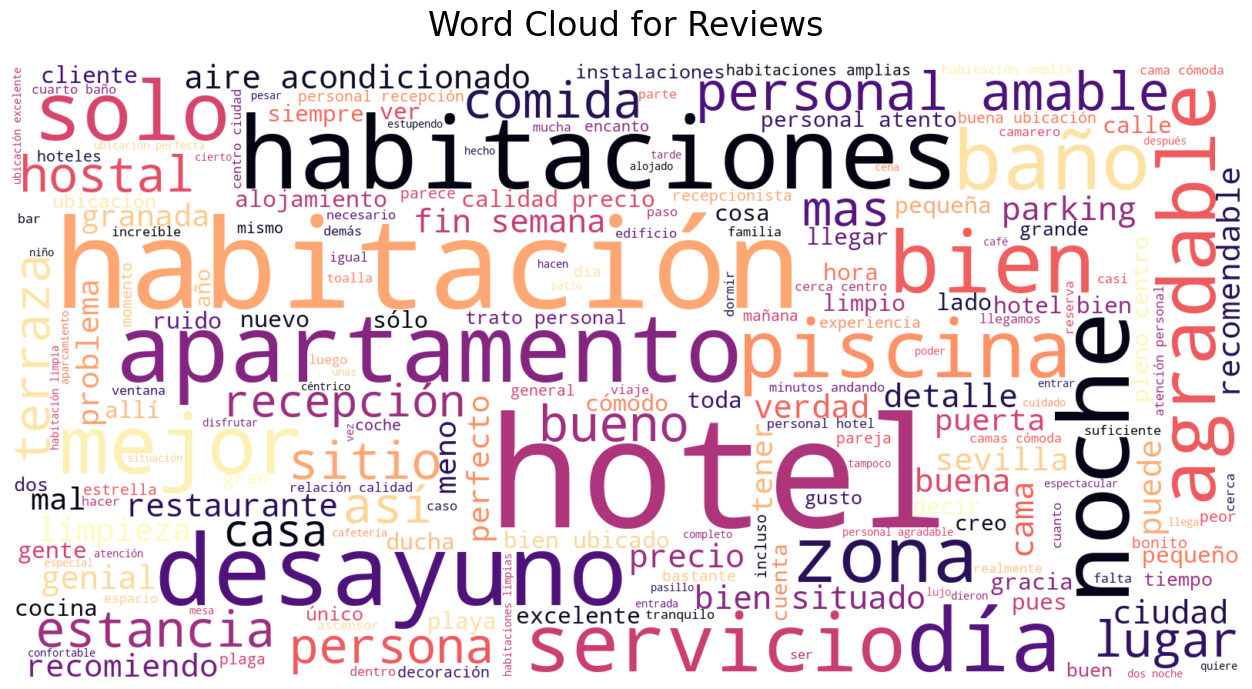

In [65]:
generate_wordcloud(reviews_df, "review_text", "wordcloud_pre_manual", random_seed)

### 3.1. Manual review

In [66]:
# Delete words that may be due to errors
wrong_words = ['ma', 'asi', 'una', 'aunque', 'además', 'hace', 'etc', 'q', 'pue', 'si', 'tan', 'sido']
reviews_df['review_text'] = reviews_df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in wrong_words]))

c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
c:\Users\charl\Desktop\Universidad\Inteligencia artificial en las organizaciones\Prácticas\practica-2\review2rating\venv\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023

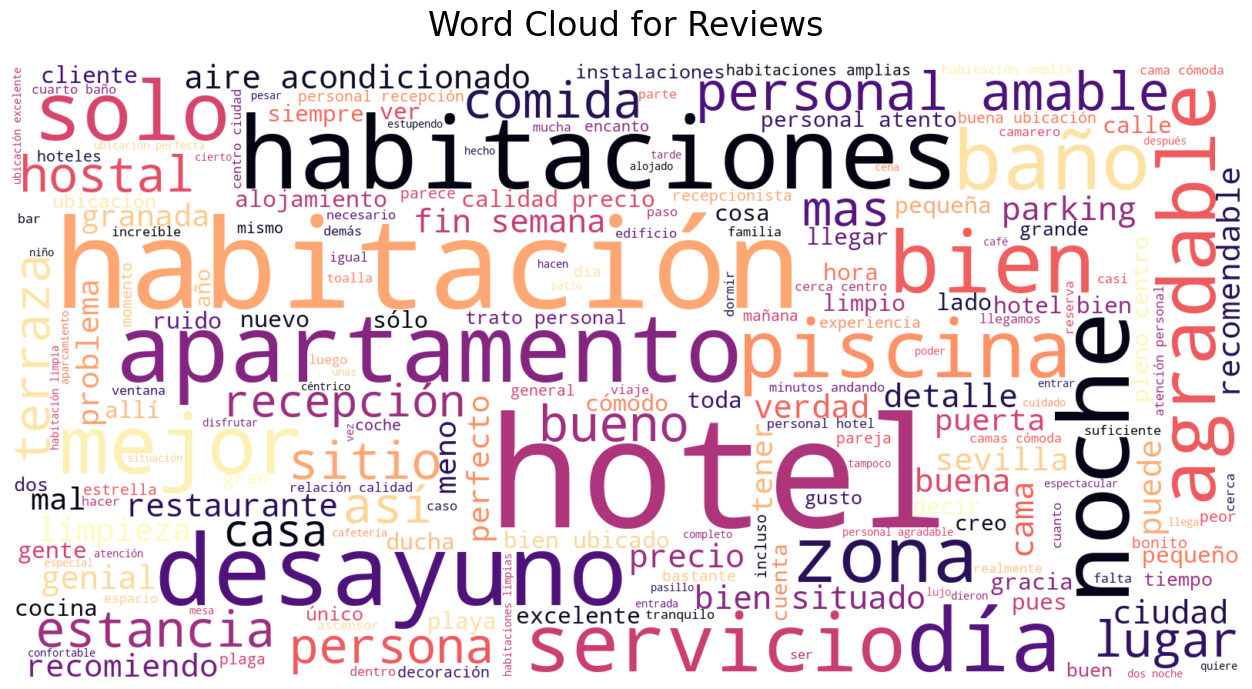

In [67]:
generate_wordcloud(reviews_df, "review_text", 'wordcloud_post_manual', random_seed)

## 4. LDA analysis

### 4.1. Tokenize words

In [68]:
# Donwload the resources for NLTK spanish tokenizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\charl\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [69]:
# Tokenize the reviews if they are not already tokenized
tokens_df = reviews_df.copy()

tokens_df['review_text'] = tokens_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

### 4.2. TF-IDF Matrix

In [70]:
# # Initialize the TF-IDF vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features as needed

# # Fit and transform the tokenized text data
# tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_df['review_text'])

In [71]:
# Tokenize the reviews if they are not already tokenized
tokens_df['review_text'] = tokens_df['review_text'].apply(lambda x: word_tokenize(x, language='spanish') if isinstance(x, str) else x)

# Create Dictionary
id2word = corpora.Dictionary(tokens_df['review_text'])

# Create Corpus
texts = tokens_df['review_text']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


## 5. LDA Training

### 5.1. LDA Model training

In [73]:
# # Initialize the LDA model
# lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can specify the number of topics (n_components)

# # Fit the LDA model to the TF-IDF matrix
# lda.fit(tfidf_matrix)

# # Extract the topic-word distributions
# topic_word_distributions = lda.components_

Better to use gensim library rather than scykitlearn

In [74]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.027*"hotel" + 0.021*"habitación" + 0.013*"bien" + 0.007*"personal" + 0.007*"centro" + 0.006*"precio" + 0.006*"habitaciones" + 0.006*"ubicación" + 0.005*"ciudad" + 0.005*"desayuno"'), (1, '0.021*"hotel" + 0.008*"habitación" + 0.008*"baño" + 0.008*"ubicación" + 0.007*"habitaciones" + 0.006*"bien" + 0.005*"buena" + 0.005*"desayuno" + 0.005*"personal" + 0.005*"dos"'), (2, '0.026*"hotel" + 0.012*"bien" + 0.011*"habitaciones" + 0.011*"personal" + 0.010*"habitación" + 0.007*"desayuno" + 0.007*"buena" + 0.005*"ubicación" + 0.005*"limpio" + 0.005*"lugar"'), (3, '0.019*"habitación" + 0.019*"hotel" + 0.011*"bien" + 0.010*"personal" + 0.008*"desayuno" + 0.008*"baño" + 0.007*"buena" + 0.007*"ubicación" + 0.007*"habitaciones" + 0.006*"centro"'), (4, '0.014*"habitación" + 0.011*"bien" + 0.011*"hotel" + 0.010*"personal" + 0.005*"habitaciones" + 0.005*"ubicación" + 0.005*"excelente" + 0.005*"mejor" + 0.005*"amable" + 0.005*"piscina"'), (5, '0.011*"hotel" + 0.011*"bien" + 0.010*"habitación" + 0.

In [75]:
# Function to display the top words for each topic
# def display_topics(model, feature_names, num_top_words=10):
#     for topic_idx, topic in enumerate(model.components_):
#         top_words_idx = topic.argsort()[-num_top_words:][::-1]
#         top_words = [feature_names[i] for i in top_words_idx]
#         print(f"Topic {topic_idx}: {', '.join(top_words)}")

# # Display the top words for each topic
# tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# display_topics(lda, tfidf_feature_names)

### 5.2. Model training

In [76]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.003820  0.001872       1        1  16.594671
9     -0.004051  0.002319       2        1  13.702778
0     -0.002673 -0.007848       3        1  13.499935
7      0.003086 -0.006776       4        1  11.250964
8     -0.014234 -0.003683       5        1   9.932492
4     -0.027299 -0.016695       6        1   8.437172
3      0.014454 -0.010860       7        1   8.347831
6      0.017484 -0.014321       8        1   6.975257
5     -0.015221  0.039825       9        1   6.012793
1      0.032273  0.016168      10        1   5.246107, topic_info=             Term          Freq         Total Category  logprob  loglift
8           hotel  13630.000000  13630.000000  Default  30.0000  30.0000
7      habitación   8837.000000   8837.000000  Default  29.0000  29.0000
94           baño   3238.000000   3238.000000  Default  28.0000  28.0000
95           bien   7060.000000   7060.000000  Default  27.0000  27.0000
74   habitaciones   5258.000000   5258.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
338          solo    100.492982   1734.571188  Topic10  -5.8477   0.0993
43          mejor    102.601678   2087.656897  Topic10  -5.8269  -0.0653
69         ciudad    102.819444   2165.340746  Topic10  -5.8248  -0.0997
165      limpieza     99.387448   2224.607047  Topic10  -5.8588  -0.1606
3           cerca     98.576200   2585.712667  Topic10  -5.8670  -0.3192

[864 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
381       1  0.050104    120
381       2  0.100208    120
381       3  0.100208    120
381       4  0.100208    120
381       5  0.100208    120
...     ...       ...    ...
82        6  0.120983  único
82        7  0.076778  único
82        8  0.043042  único
82        9  0.065145  único
82       10  0.015123  único

[2346 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 1, 8, 9, 5, 4, 7, 6, 2])

In [77]:
# number of topics
num_topics = 4

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.019*"hotel" + 0.012*"habitación" + 0.009*"bien" + 0.008*"habitaciones" + 0.007*"personal" + 0.007*"centro" + 0.006*"baño" + 0.006*"lugar" + 0.005*"amable" + 0.005*"buena"'), (1, '0.016*"habitación" + 0.010*"hotel" + 0.010*"bien" + 0.008*"habitaciones" + 0.007*"ubicación" + 0.007*"desayuno" + 0.006*"personal" + 0.005*"centro" + 0.005*"zona" + 0.005*"cerca"'), (2, '0.024*"hotel" + 0.016*"habitación" + 0.010*"personal" + 0.010*"bien" + 0.008*"desayuno" + 0.006*"habitaciones" + 0.005*"ubicación" + 0.005*"buena" + 0.005*"recepción" + 0.005*"centro"'), (3, '0.026*"hotel" + 0.013*"bien" + 0.010*"personal" + 0.010*"habitación" + 0.009*"habitaciones" + 0.006*"buena" + 0.006*"ubicación" + 0.006*"desayuno" + 0.006*"baño" + 0.005*"cerca"')]


In [78]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.009576  0.005289       1        1  29.520296
2     -0.006880 -0.015054       2        1  25.609739
0     -0.002261  0.011236       3        1  23.095849
1      0.018717 -0.001470       4        1  21.774117, topic_info=           Term          Freq         Total Category  logprob  loglift
8         hotel  13620.000000  13620.000000  Default  30.0000  30.0000
7    habitación   8787.000000   8787.000000  Default  29.0000  29.0000
75        lugar   2308.000000   2308.000000  Default  28.0000  28.0000
16    ubicación   3662.000000   3662.000000  Default  27.0000  27.0000
201    atención   2034.000000   2034.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
165    limpieza    479.323267   2243.744010   Topic4  -5.7087  -0.0191
94         baño    544.023340   3249.693493   Topic4  -5.5820  -0.2629
55    excelente    476.439924   2411.229681   Topic4  -5.7147  -0.0971
503      precio    481.580128   2758.846994   Topic4  -5.7040  -0.2210
140   recepción    460.545671   2720.799116   Topic4  -5.7486  -0.2518

[377 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
19403      2  0.215150       209
19403      3  0.645450       209
19404      2  0.214956  26062020
19404      3  0.644867  26062020
14574      4  0.688351      3108
...      ...       ...       ...
111        3  0.235153      zona
111        4  0.318653      zona
13802      1  0.172735     zorro
13802      3  0.172735     zorro
13802      4  0.690942     zorro

[720 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])